In [4]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], step_fun="step", start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._step_fun=step_fun 
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
            
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            #why do like this?
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()

            #dI = torch.rand(self._n, requires_grad=True).to(device) < dI 
            #random will effect the result, less than operation will lose gradient
            if self._step_fun=="sigmoid":
                activeM= torch.nn.Sigmoid()
                dI= activeM(1000*(dI-dIsample))
            elif self._step_fun=="step":
                dI= dI>dIsample
                
            I = torch.max(I, dI) # got infected

            states[self._states_names['I']] = I

        return states
    def get_random_from_samples(self):
        return self._samples[self._t-1]

In [5]:
def sim(time_horizon, population, model):
  log = [population['I']]
  for i in range(time_horizon):
    population = model(population)
    log.append(population['I'])  
  log = torch.stack(log)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log

tensor(10000., device='cuda:0')


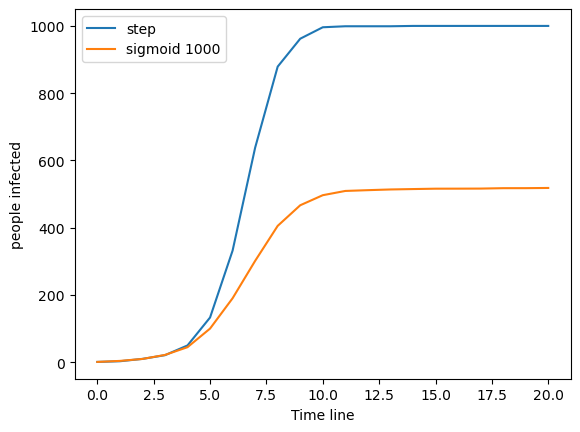

In [6]:
n = 1000 # population
avgDegree = 10  #every individual will have 10 contacts on average
pinf = 0.2  #it is the first parameter we are going to fit
time_horizon = 20
#create  dense contacts
contacts = generate_random_network(n, avgDegree)
contacts = contacts.coalesce()#make pairs unique
print(contacts.values().sum())
contacts = contacts.to_dense()
contacts = contacts.requires_grad_(True)
#random to be used
dIsamples=[]
for _ in range(time_horizon):
    dIsamples.append(torch.rand(n).to(device))
#si
si_step =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                  step_fun="step", samples=dIsamples, device=device)
si_sigm =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                  step_fun="sigmoid", samples=dIsamples, device=device)
#generate real data
si_step_result= None
si_sigm_result= None
with torch.no_grad():
    population = Population(n, device=device)
    si_step_result = sim(time_horizon,population,si_step)
with torch.no_grad():
    population = Population(n, device=device)
    si_sigm_result = sim(time_horizon,population,si_sigm)
colors = [("red", "step"), ("green", "sigmoid")]
age_sizes = [n]
si_step_result= si_step_result.squeeze()
si_sigm_result= si_sigm_result.squeeze()
plt.plot(si_step_result.sum(dim=1).cpu(), label='step')
plt.plot(si_sigm_result.sum(dim=1).cpu(), label='sigmoid 1000')
plt.xlabel("Time line")
plt.ylabel("people infected")
plt.legend()
